# Train a loose version of Caption-ja letter classifier

Goal: **Classify letters into digits, :, /, ~ and others**

Let relevant letters = `{0-9, :, /, ~}`

But this time, allow confusion between letters and numbers, such as, (2,z) (5,s) (0,o,O), (1,I,i,l) (9,g)
Even if we classify z or s as relevant letters, we still can identify date-time by regex of DD/DD/DD HH:MM.
Bu if we misclassify 2 as z and thus exclude from relevant string, then we can not identify the date time.
In other words, false positives are acceptable.


Steps


1. Remove background columns (not rows) from all input data

2. Get the maximum size of relevant letters -> `(nr, nc)`

3. filter out the data with size larger than `(nr+4, nc+4)`

4. Pad all remaing data to the size `(nr+4, nc+4)`

5. Train classification model on the created data
  

In [56]:
import os
import sys
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.image import ImageDataGenerator

In [57]:
proj_root = os.path.abspath(os.path.join('../')) 
datadir = os.path.join(proj_root, 'data/caption/')
modeldir = os.path.join(proj_root, 'models/')
arcdir = os.path.join(proj_root, 'models/archive')

if not os.path.isdir(datadir): 
    print('data directory not found', os.path.abspath(datadir))
    raise
if not os.path.isdir(modeldir): os.path.makedirs(modeldir)
if not os.path.isdir(modeldir): os.path.makedirs(arcdir)

In [58]:
module_path = os.path.join(proj_root, 'kgschart')
sys.path.append(module_path)
from utils import pad_image

In [59]:
X = np.load(os.path.join(datadir, 'X-ja.npy'))
Y = np.load(os.path.join(datadir, 'Y-ja.npy'))

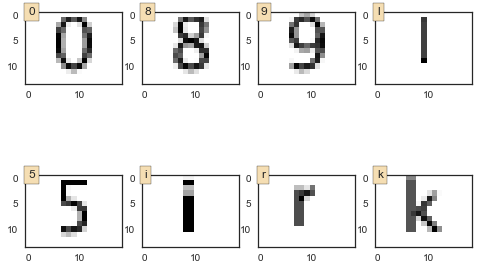

In [60]:
# convenient functions
def random_plot(X, Y, predicted=None):
    sns.set_style('white')
    indices = np.random.choice(len(Y), min(8, len(Y)))
    count = 0
    for i in indices:
        count += 1
        ax = plt.subplot(2, 4, count)
        ax.imshow(X[i], cmap='gray')
        text = Y[i] if predicted is None else 'tr: %s, pr: %s' % (Y[i], predicted[i])
        ax.text(0, 0, text, bbox={'facecolor':"wheat"})
    plt.show(block=False)

random_plot(X, Y)


def compare_plot(X1, X2):
    sns.set_style('white')
    indices = range(3) if len(X1) <= 3 else np.random.choice(len(X1), 3)
    count = 0
    for i in indices:
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X1[i], cmap='gray')
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X2[i], cmap='gray')
    plt.show(block=False)

def generate_augmented_data(X, Y, target_size, seed=None):
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                 data_format='channels_last', channel_shift_range=0.5)
    out_X = None
    out_Y = None
    for x,y in datagen.flow(np.expand_dims(X, axis=4), Y, seed=seed):
        if out_X is None:
            out_X = x
            out_Y = y
        else:
            out_X = np.vstack([out_X, x])
            out_Y = np.concatenate([out_Y, y])
        if len(out_Y) >= target_size: 
            break
    out_X = out_X.squeeze()
    return out_X, out_Y


def diagnosis(fit, X, Y):
    print('accuracy = ', fit.score(X, Y))
    pred = fit.predict(X)
    wrong = (Y != pred)
    if np.any(wrong):
        random_plot(X[wrong], Y[wrong], pred[wrong])
    #print(classification_report(Y, pred))
    print(pd.crosstab(pd.Series(Y), pd.Series(pred), margins=True))



## Step 1 Remove background from all input data

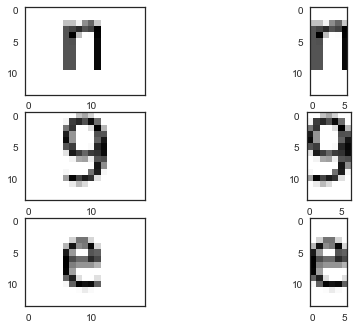

In [61]:
def remove_background(x, bg = 1.0, rows=False, cols=True):
    """
    from a image array of size (nrow, ncol),
    remove all rows and cols where values are all bg
    """
    not_bg = (x != bg)
    non_bg_rows = np.any(not_bg, axis=1)
    non_bg_cols = np.any(not_bg, axis=0)
    
    if rows:
        tmp = non_bg_rows.nonzero()[0]
        if len(tmp) == 0: return None
        i1 = tmp[0]
        i2 = tmp[-1] + 1
    else:
        i1 = 0
        i2 = x.shape[0]
    
    if cols:
        tmp = non_bg_cols.nonzero()[0]
        if len(tmp) == 0: return None
        j1 = tmp[0]
        j2 = tmp[-1] + 1
    else:
        j1 = 0
        j2 = x.shape[1]
        
    return x[i1:i2, j1:j2]

X_nobg = [remove_background(x, rows=False) for x in X]
compare_plot(X, X_nobg)

## Step 2 Get the maximum size of relevant letters -> (nr, nc)

In [62]:
max_rows = 0
max_cols = 0

relevant_letters = [s for s in '0123456789/:?']
for i in range(len(Y)):
    if Y[i] in relevant_letters:
        max_rows = max(X_nobg[i].shape[0], max_rows)
        max_cols = max(X_nobg[i].shape[1], max_cols)
print(max_rows, max_cols)

14 7


## Step 3 filter out the data with size larger than (nr+4, nc+4)

target shape = (18, 11)
total: 109, included: 105, out: 4
non-included samples


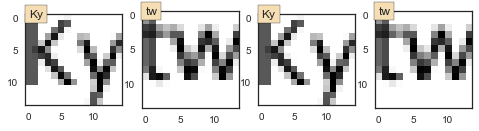

included samples


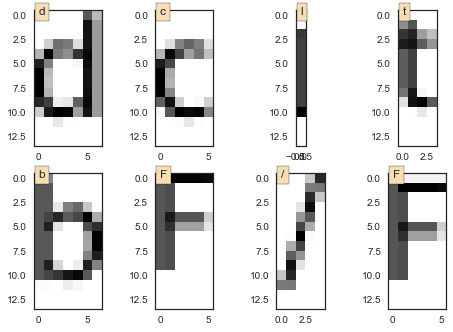

In [63]:
target_shape = (max_rows+4, max_cols+4)
print("target shape =", target_shape)
X_out = []
Y_out = []
X_in = []
Y_in = []
for i in range(len(Y)):
    #print(i, X_nobg[i].shape)
    if X_nobg[i].shape[0] <= target_shape[0] and X_nobg[i].shape[1] <= target_shape[1]:
        X_in.append(X_nobg[i])
        Y_in.append(Y[i])
    else:
        X_out.append(X_nobg[i])
        Y_out.append(Y[i])
print('total: %d, included: %d, out: %d' % (len(Y), len(Y_in), len(Y_out)))

print('non-included samples')
random_plot(X_out, Y_out)

print('included samples')
random_plot(X_in, Y_in)


## Step 4 Pad all remaing data to the size (nr+4, nc+4)

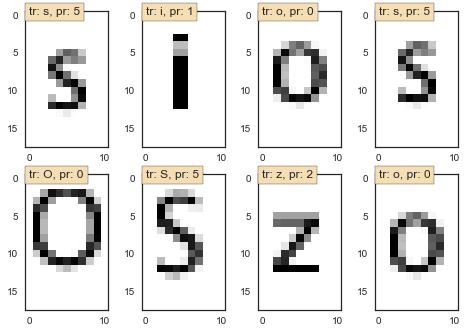

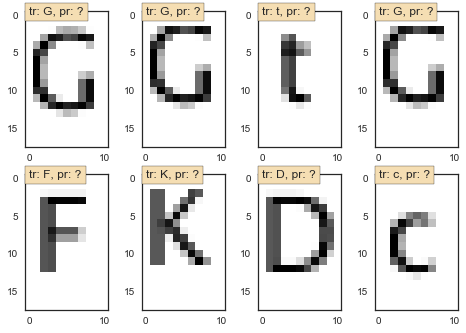

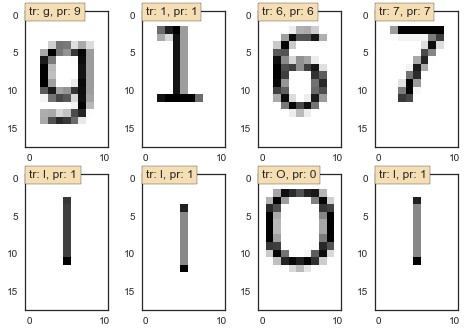

In [64]:
X_in = [pad_image(x, target_shape[0], target_shape[1], 1.0) for x in X_in]
X_in = [np.expand_dims(x, axis=0) for x in X_in]
X_in = np.vstack(X_in)

Y_in = np.array(Y_in)

allowed_confusions = [
    ('2', 'z'), ('2', 'Z'),
    ('5', 's'), ('5', 'S'), 
    ('9', 'g'), 
    ('0', 'o'), ('0', 'O'), 
    ('1', 'I'), ('1', 'i'), ('1', 'l')
]
Y_in2 = np.array([y for y in Y_in])
for a in allowed_confusions:
    Y_in2[Y_in == a[1]] = a[0]
 
random_plot(X_in[Y_in != Y_in2], Y_in[Y_in != Y_in2], Y_in2[Y_in != Y_in2])

for i in range(len(Y_in2)):
    if not Y_in2[i] in relevant_letters:
        Y_in2[i] = '?'

random_plot(X_in[Y_in2 == '?'], Y_in[Y_in2 == '?'], Y_in2[Y_in2 == '?'])

random_plot(X_in[Y_in2 != '?'], Y_in[Y_in2 != '?'], Y_in2[Y_in2 != '?'])


## Step 5 Train classification model

In [65]:
# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X_in, Y_in2, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X_in, Y_in2, 5000, seed = 7)

In [66]:
# benchmark fit with support vector machine

# used for data preprocess
class Flatten:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)
    def get_params(self, deep=True):
        return {}

    

### Consider Dimensionality reduction with PCA

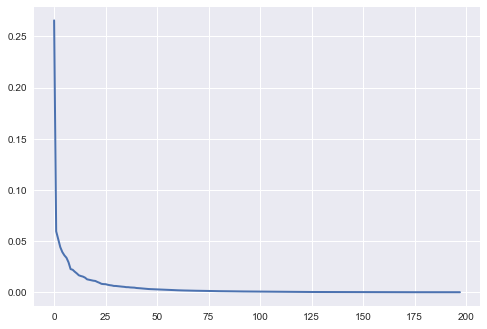

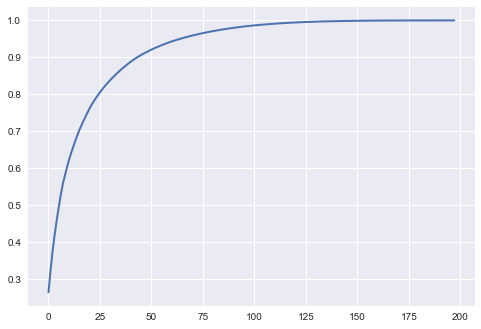

1 0.265655860153
2 0.32519570516
3 0.377113965991
4 0.421118811853
5 0.460312545767
6 0.496308122333
7 0.529956849393
8 0.559142948908
9 0.581739304799
10 0.603683565478
11 0.623750733001
12 0.642165886643
13 0.658699982108
14 0.674516466687
15 0.689775129713
16 0.704025808365
17 0.716629398776
18 0.728780556851
19 0.74044301583
20 0.751707057237
21 0.76271368785
22 0.772736143686
23 0.781940867711
24 0.790128330311
25 0.798053135893
26 0.805885674845
27 0.813181003545
28 0.820056840805
29 0.826672575236
30 0.832816600389
31 0.838910694568
32 0.844762561024
33 0.85036572771
34 0.855801263137
35 0.86105217741
36 0.865997217978
37 0.870905008864
38 0.875570348307
39 0.880129103542
40 0.884583287425
41 0.888698155627
42 0.892691939405
43 0.89649917233
44 0.900102274192
45 0.903538609575
46 0.906768718314
47 0.909855885242
48 0.912850780837
49 0.915683055538
50 0.918443239982
51 0.92117952399
52 0.923803335441
53 0.92625402506
54 0.928630045222
55 0.930995690556
56 0.933218531376
57 0.9354

In [67]:
pipe_pca = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA())
])

pipe_pca.fit(X_train)
sns.set()
plt.plot(pipe_pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pipe_pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])

Maybe 100?

### Fit MLP

accuracy =  1.0
col_0  /  0   1  2  3  4  5  6  7  8  9  :   ?  All
row_0                                              
/      3  0   0  0  0  0  0  0  0  0  0  0   0    3
0      0  6   0  0  0  0  0  0  0  0  0  0   0    6
1      0  0  11  0  0  0  0  0  0  0  0  0   0   11
2      0  0   0  5  0  0  0  0  0  0  0  0   0    5
3      0  0   0  0  3  0  0  0  0  0  0  0   0    3
4      0  0   0  0  0  3  0  0  0  0  0  0   0    3
5      0  0   0  0  0  0  8  0  0  0  0  0   0    8
6      0  0   0  0  0  0  0  3  0  0  0  0   0    3
7      0  0   0  0  0  0  0  0  3  0  0  0   0    3
8      0  0   0  0  0  0  0  0  0  2  0  0   0    2
9      0  0   0  0  0  0  0  0  0  0  5  0   0    5
:      0  0   0  0  0  0  0  0  0  0  0  2   0    2
?      0  0   0  0  0  0  0  0  0  0  0  0  51   51
All    3  6  11  5  3  3  8  3  3  2  5  2  51  105
accuracy =  0.988308184271


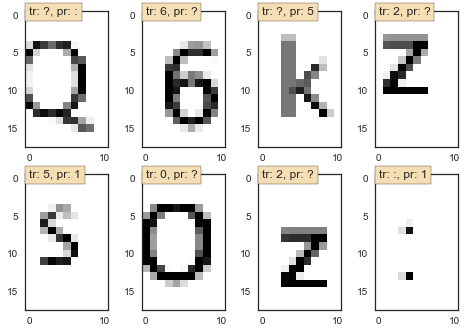

col_0    /    0     1    2    3    4    5    6    7    8    9    :     ?  \
row_0                                                                      
/      286    0     0    0    0    0    0    0    0    0    0    0     0   
0        0  554     0    0    0    0    0    0    0    0    5    0    13   
1        0    0  1046    0    0    0    0    0    0    0    0    0     3   
2        1    0     0  465    0    0    0    0    1    0    1    0     9   
3        0    0     1    0  283    0    1    0    0    1    0    0     0   
4        0    0     0    0    0  285    0    0    0    0    0    0     0   
5        0    0     4    0    1    0  749    0    0    0    0    0     9   
6        0    0     0    0    0    0    0  274    0    0    0    0    11   
7        0    0     0    0    0    0    0    0  285    0    0    0     0   
8        0    0     0    0    0    0    0    0    0  190    0    0     1   
9        0    0     0    0    0    0    0    0    1    0  474    0     2   
:        0  

In [68]:
pipe_mlp = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.01))
])    

pipe_mlp.fit(X_train, Y_train)


diagnosis(pipe_mlp, X_in, Y_in2)
diagnosis(pipe_mlp, X_test, Y_test)

MLP is just amazing... We already have 99% accuracy...

#### Exhaustive training until perfect accuracy

In [69]:
np.random.seed(87)

# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=100)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

model = MLPClassifier((100,100,100), alpha=0.01, warm_start=True)
#model = MLPClassifier((100,100), alpha=0.001, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])

classes = pipe_mlp.classes_

train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                               data_format='channels_last', channel_shift_range=0.5)

num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X_in, Y_in2, 1000)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X_in, Y_in2)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

1009 score on test = 0.484860597582 score on original = 0.485714285714
101909 score on test = 0.992105526132 score on original = 1.0
202809 score on test = 0.999900069951 score on original = 1.0
303709 score on test = 1.0 score on original = 1.0
DONE!


In [70]:
diagnosis(pipe_pred, X_in, Y_in2)
diagnosis(pipe_pred, X_test, Y_test)

accuracy =  1.0
col_0  /  0   1  2  3  4  5  6  7  8  9  :   ?  All
row_0                                              
/      3  0   0  0  0  0  0  0  0  0  0  0   0    3
0      0  6   0  0  0  0  0  0  0  0  0  0   0    6
1      0  0  11  0  0  0  0  0  0  0  0  0   0   11
2      0  0   0  5  0  0  0  0  0  0  0  0   0    5
3      0  0   0  0  3  0  0  0  0  0  0  0   0    3
4      0  0   0  0  0  3  0  0  0  0  0  0   0    3
5      0  0   0  0  0  0  8  0  0  0  0  0   0    8
6      0  0   0  0  0  0  0  3  0  0  0  0   0    3
7      0  0   0  0  0  0  0  0  3  0  0  0   0    3
8      0  0   0  0  0  0  0  0  0  2  0  0   0    2
9      0  0   0  0  0  0  0  0  0  0  5  0   0    5
:      0  0   0  0  0  0  0  0  0  0  0  2   0    2
?      0  0   0  0  0  0  0  0  0  0  0  0  51   51
All    3  6  11  5  3  3  8  3  3  2  5  2  51  105
accuracy =  1.0
col_0    /    0     1    2    3    4    5    6    7    8    9    :     ?  \
row_0                                                       

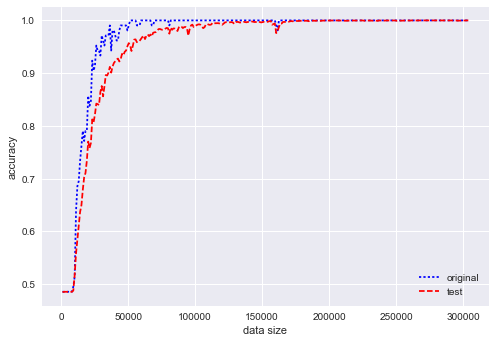

In [71]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [72]:
# save PCA-MLP part
savename = os.path.join(modeldir, 'caption-ja-loose_pca-mlp-full.pkl')
pipe = Pipeline([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

['C:\\Users\\Kota.Mori\\Documents\\_dev\\kgschart\\models/caption-ja-loose_pca-mlp-full.pkl']

In [73]:
with open(os.path.join(modeldir, 'caption-ja-loose-config.json'), 'w') as file:
    json.dump(dict(input_shape=X_in.shape[1:], 
                   allowed_confusions=allowed_confusions), file)